In [22]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from plot import plot_learning
import matplotlib.pyplot as plt
from get_utils import get_loss
import numpy as np
import seaborn as sb
from utils import modelLoss
import pandas as pd
import scipy.stats as stats



#%matplotlib qt
#%matplotlib widget
%matplotlib inline


fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

def create_dataframe(idx, siz, loss_type, target):
    data = []
    for p in list(idx.keys()):
        val = idx[p]
        data.extend([
            {'mn': i + 1, 'phase': p, 'value': v, 'size': siz, 'lt': loss_type, 'target': target}
            for i, v in enumerate(val)
        ])
    return pd.DataFrame(data)

In [96]:
# Load loss
phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
palette_colors = {'FF1': 'g', 'FF2': 'r', 'NF1': 'k', 'NF2': 'k'}
num_model = 20
ignore = []
target = None
loss_type = 'lateral'

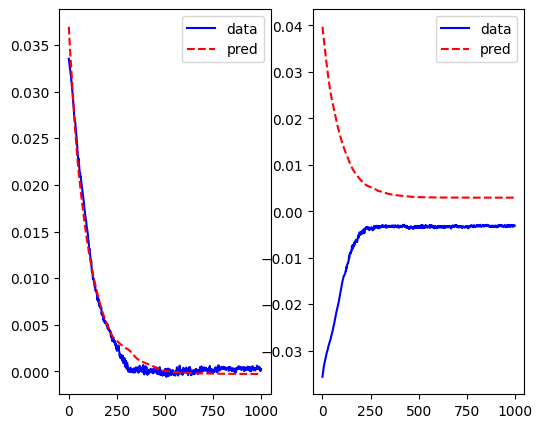

In [93]:
T = pd.DataFrame()
L = pd.DataFrame()


for s in [128]:

    folder_name = f'Sim_all_{s}_inv'

    #for t in range(8):
    loss = get_loss(folder_name,num_model,phases,loss_type=loss_type,w=1,ignore=ignore,target=None)

    # get initial loss
    data1 = {'NF1':[],'FF1':[],'NF2':[],'FF2':[]}
    for p in list(data1.keys()):
        index=0
        if p=='NF1' or p=='NF2':
            index=-1
        if p=='FF2':
            
            data1[p] = list(-np.array(loss[p])[:,index])
        else:
            data1[p] = list(np.array(loss[p])[:,index])

    # Fit data
    loss = get_loss(folder_name,num_model,phases,loss_type=loss_type,w=10,ignore=ignore,target=None)
    data2 = {'FF1':[],'FF2':[]}
    pred = {'FF1':[],'FF2':[]}
    for m in range(len(loss['FF1'])):
        for i,phase in enumerate(data2.keys()):
            l = loss[phase][m]
            if phase=='FF2':
                l=-l
            model = modelLoss()
            if loss_type == 'position':
                theta0=None
            else:
                theta0=[np.log(l[0]),np.log(0.004),l[-1]]
            model.fit(l,lam=0.0,theta0=theta0)

            pred[phase].append(model.predict())
            data2[phase].append(model.get_rate())
    
    # Check the fits
    fig,ax = plt.subplots(1,2,figsize=(6,5))
    ax[0].plot(np.median(loss['FF1'],axis=0),linestyle='-',color='b',label='data')
    ax[0].plot(np.median(pred['FF1'],axis=0),linestyle='--',color='r',label='pred')
    ax[0].legend()

    ax[1].plot(np.median(loss['FF2'],axis=0),linestyle='-',color='b',label='data')
    ax[1].plot(np.median(pred['FF2'],axis=0),linestyle='--',color='r',label='pred')
    ax[1].legend()
    plt.show()

    T = pd.concat([T, create_dataframe(data1, s, loss_type, 'all')], ignore_index=True)
    L = pd.concat([L, create_dataframe(data2, s, loss_type, 'all')], ignore_index=True)

T.to_csv(base_dir+'/loss_init_neg.csv',index=False)
L.to_csv(base_dir+'/loss_rate_neg.csv',index=False)

# Plot #1: Learning all phases - only for 128

In [97]:
folder_name = f'Sim_all_{128}'
target = 5
loss = get_loss(folder_name,num_model,phases,loss_type=loss_type,w=1,ignore=ignore,target=None)

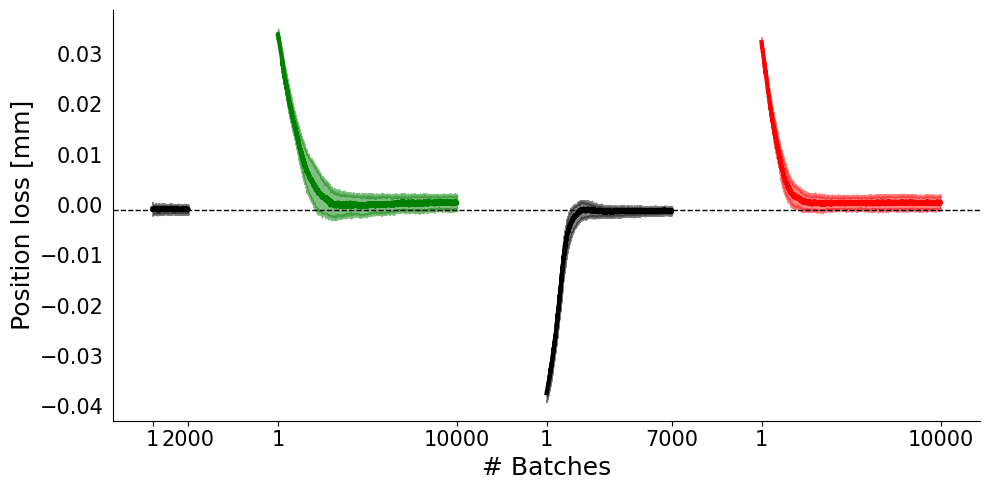

In [107]:
fig, ax = plot_learning(loss,figsize=(10,5),show_saving=False,gap=5000,palette_colors=palette_colors)


ax[0].set_xlabel('# Batches', fontsize = fontsize_label)
ax[0].set_ylabel('Position loss [mm]', fontsize = fontsize_label)
ax[0].legend(title = '',frameon = False, bbox_to_anchor= (1,1), fontsize=fontsize_legend)
ax[0].legend().set_visible(False)
ax[0].xaxis.set_tick_params(labelsize=fontsize_tick)
ax[0].yaxis.set_tick_params(labelsize=fontsize_tick)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
plt.tick_params(left = False) 

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(save_fig,'learnings.pdf'),dpi=300,bbox_inches='tight')

# Plot #2: initial value of loss - only for 128

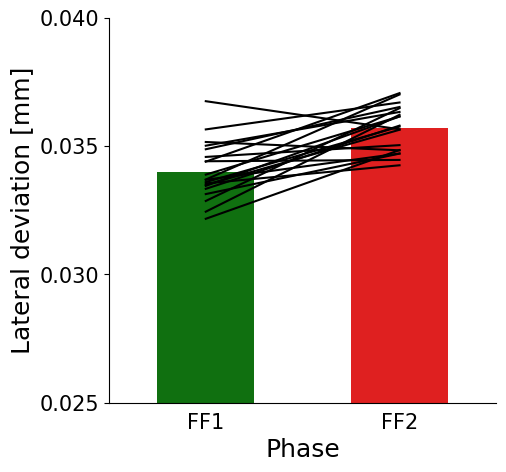

In [111]:
# plot saving for FF1 and FF2
T = pd.read_csv(base_dir+'/loss_init_neg.csv')
D = T[(T['phase'].isin(['FF1', 'FF2'])) & (T['size'] == 128)]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for id, data in D.groupby('mn'):
    ff1_value = data[data['phase'] == 'FF1']['value'].values[0]
    ff2_value = data[data['phase'] == 'FF2']['value'].values[0]
    ax.plot(['FF1', 'FF2'], [ff1_value, ff2_value], color='k')


sb.barplot(x='phase', y='value', data=D, hue='phase', width=0.5, ax=ax, palette=palette_colors,errorbar=None)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom=False)
ax.set_xlabel('Phase', fontsize=fontsize_label)
ax.set_ylabel('Lateral deviation [mm]', fontsize=fontsize_label)

#ax.set_ylim([32, 41])  # Adjust based on your data
ax.set_ylim([0.025, 0.04])
ax.set_yticks([0.025, 0.03, 0.035, 0.04])
fig.savefig(os.path.join(save_fig, 'saving_batch0_lat_neg.pdf'), dpi=300, bbox_inches='tight')

#  Plot #2: Learning rate - for 128

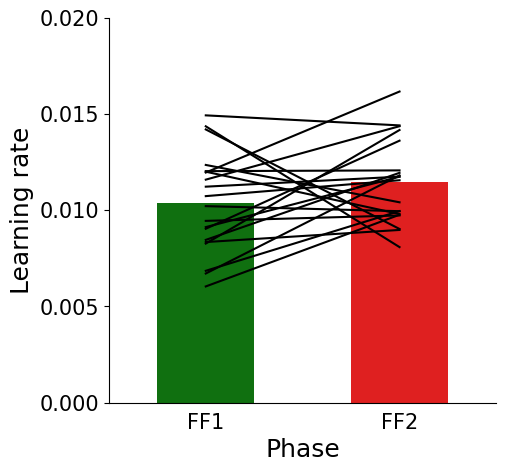

In [116]:
L = pd.read_csv(base_dir+'/loss_rate_neg.csv')
D = L[(L['phase'].isin(['FF1', 'FF2'])) & (L['size'] == 128)]


fig, ax = plt.subplots(1, 1, figsize=(5, 5))


for id, data in D.groupby('mn'):
    ff1_value = data[data['phase'] == 'FF1']['value'].values[0]
    ff2_value = data[data['phase'] == 'FF2']['value'].values[0]
    ax.plot(['FF1', 'FF2'], [ff1_value, ff2_value], color='k')


sb.barplot(x='phase', y='value', data=D, hue='phase', width=0.5, ax=ax, palette=palette_colors,errorbar=None)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom=False)
ax.set_xlabel('Phase', fontsize=fontsize_label)
ax.set_ylabel('Learning rate', fontsize=fontsize_label)

ax.set_ylim([0.00, 0.02])
ax.set_yticks([0.00,0.005, 0.01, 0.015,0.02])
fig.savefig(os.path.join(save_fig, 'saving_batch0_lat_lr_neg.pdf'), dpi=300, bbox_inches='tight')

# Plot #3: initial loss all

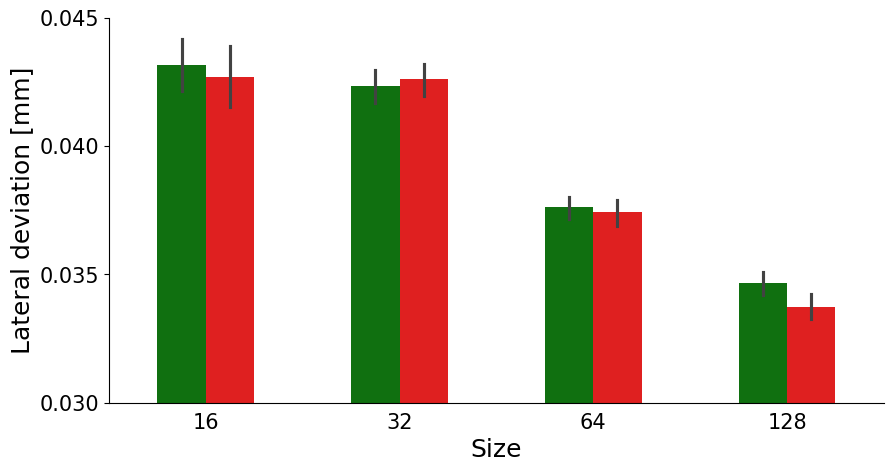

In [140]:
L = pd.read_csv(base_dir+'/loss_init.csv')
#D = L[L['phase'].isin(['FF1', 'FF2'])]
D = L[(L['phase'].isin(['FF1', 'FF2']))]  #& (L['target'] == 5) 


fig, ax = plt.subplots(1, 1, figsize=(10, 5))



sb.barplot(x='size', y='value', data=D, hue='phase', width=0.5, ax=ax, palette=palette_colors) # ,errorbar=None


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom=False)
ax.set_xlabel('Size', fontsize=fontsize_label)
ax.set_ylabel('Lateral deviation [mm]', fontsize=fontsize_label)

ax.set_ylim([0.03, 0.045])
ax.set_yticks([0.03,0.035, 0.04,0.045])
ax.legend().set_visible(False)


fig.savefig(os.path.join(save_fig, 'perf_vs_size.pdf'), dpi=300, bbox_inches='tight')
# for size in D['size'].unique():
#     data_size_ff1 = D[(D['size'] == size) & (D['phase'] == 'FF1')]['value']
#     data_size_ff2 = D[(D['size'] == size) & (D['phase'] == 'FF2')]['value']
#     t_stat, p_value = stats.ttest_rel(data_size_ff1, data_size_ff2)
#     print(f"T-test for size {size}: t-statistic = {t_stat}, p-value = {p_value}")
#ax.set_ylim([0.03, 0.05])

# Plot #4: difference between FF1 and FF2

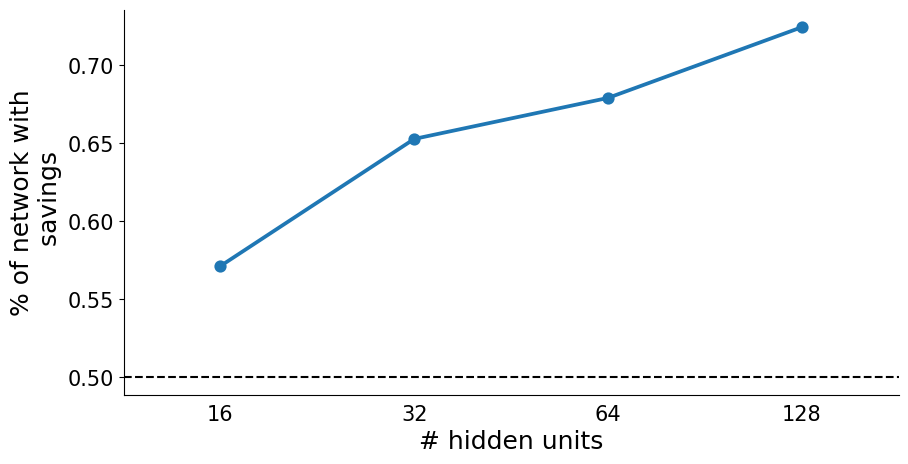

In [132]:
L = pd.read_csv(base_dir+'/loss_rate.csv')
L2 = pd.read_csv(base_dir+'/loss_rate.csv')

D = L[(L['phase'].isin(['FF1','FF2']))] #  & (L['target'] == 5)
D2 = L2[(L2['phase'].isin(['FF1','FF2']))] #  & (L['target'] == 5)



ff1_data = D[D['phase']=='FF1']
ff2_data = D[D['phase']=='FF2']

ff1_data2 = D2[D2['phase']=='FF1']
ff2_data2 = D2[D2['phase']=='FF2']

merged_data = pd.merge(ff1_data,ff2_data,on='size',suffixes=('_ff1', '_ff2'))

merged_data2 = pd.merge(ff1_data2,ff2_data2,on='size',suffixes=('_ff1', '_ff2'))


# Calculate the difference in 'loss'
merged_data['loss_difference'] = (merged_data['value_ff2']-merged_data['value_ff1']>0) #& (merged_data2['value_ff2']-merged_data2['value_ff1']>0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sb.pointplot(x='size', y='loss_difference', data=merged_data, ax=ax,errorbar=None) #,errorbar=None

ax.axhline(0.5, color='black', linestyle='--')

#ax.set_ylim([33,37])  
#ax.set_ylim([-0.001, 0.0015])
#ax.set_yticks([-0.0005, 0,0.0005, 0.001])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('# hidden units', fontsize = fontsize_label)
ax.set_ylabel('% of network with\n savings', fontsize = fontsize_label)

plt.show()

fig.savefig(os.path.join(save_fig,'saving_vs_size.pdf'),dpi=300,bbox_inches='tight')
